In [38]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.sm_exceptions import ValueWarning

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=ValueWarning, module='statsmodels')

# Functions
# Add the directory containing the module to sys.path
sys.path.append(os.path.abspath('functions'))
from preprocessing import read_csv_files, check_missing_values, forward_fill, backward_fill, linear_interpolation, calculate_volatility, adf_test, map_date_range, create_volatility_df
from spillover import calculate_avg_spillover_table, calculate_net_pairwise_spillover_table, calculate_rolling_spillover_table, fit_var

## Data Preprocessing

In [39]:
# Retrieve a list of DataFrames
dataframes = read_csv_files("data")

In [40]:
# Convert each column in every DataFrame to lowercase
for key in dataframes:
    dataframes[key].columns = map(str.lower, dataframes[key].columns)

Converting the `date` column to datetime object, this process has to be handled individually since each DataFrame has a different date format. We cannot let Pandas infers the date format for each DataFrame since it can be prone to infer the wrong format. Below are the format of each DataFrame:
- Philippines: MM/DD/YYYY
- Singapore: MM/DD/YYYY
- India: YYYY-MM-DD
- United Kingdom: DD/MM/YYYY
- Mexico: YYYY-MM-DD
- Japan: YYYY-MM-DD
- Vietnam: DD/MM/YYYY
- Korea: YYYY-MM-DD
- Thailand: YYYY-MM-DD
- Brazil: YYYY-MM-DD
- Malaysia: DD/MM/YYYY
- Switzerland: YYYY-MM-DD
- China: DD/MM/YYYY
- Russia: YYYY-MM-DD
- United States: YYYY-MM-DD

In [41]:
date_format_mapping = {
  'philippines': '%m/%d/%Y',
  'singapore': '%m/%d/%Y',
  'india': '%Y-%m-%d',
  'uk': '%d/%m/%Y',
  'mexico': '%Y-%m-%d',
  'japan': '%Y-%m-%d',
  'vietnam': '%d/%m/%Y',
  'korea': '%Y-%m-%d',
  'thailand': '%Y-%m-%d',
  'brazil': '%Y-%m-%d',
  'malaysia': '%d/%m/%Y',
  'switzerland': '%Y-%m-%d',
  'china': '%d/%m/%Y',
  'russia': '%Y-%m-%d',
  'us': '%Y-%m-%d',
}

# Convert the date columns to datetime objects
for key in dataframes:
    try:
      dataframes[key]['date'] = pd.to_datetime(
        dataframes[key]['date'], 
        format=date_format_mapping[key]
      )
    except Exception as e:
      print(f"Error occurred for country: {key}")
      print(f"Error message: {str(e)}")

In [42]:
# Sort the dataframes by date in ascending order
for key in dataframes:
    dataframes[key] = dataframes[key].sort_values(by='date')

In [43]:
# Reset the index of the dataframes
for key in dataframes:
    dataframes[key] = dataframes[key].reset_index(drop=True)

In [44]:
# Extract only open, high, low, close columns
for key in dataframes:
    dataframes[key] = dataframes[key][['date', 'open', 'high', 'low', 'close']]

In [45]:
for df in dataframes.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5597 non-null   datetime64[ns]
 1   open    5597 non-null   object        
 2   high    5597 non-null   object        
 3   low     5597 non-null   object        
 4   close   5597 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 218.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5656 non-null   datetime64[ns]
 1   open    5607 non-null   float64       
 2   high    5607 non-null   float64       
 3   low     5607 non-null   float64       
 4   close   5607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 221.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Ra

Since the columns open, high, low, close have different dtypes (`float64` and `object`) for different DataFrame, they should be converted to `float64`.

In [46]:
# Convert open, high, low, close columns to float
for key in dataframes:
  for col in ['open', 'high', 'low', 'close']:
    if dataframes[key][col].dtype == 'object':
      dataframes[key][col] = dataframes[key][col].str.replace(',', '').astype(float)


In [47]:
# Check whether the columns have been converted to float
for df in dataframes.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5597 non-null   datetime64[ns]
 1   open    5597 non-null   float64       
 2   high    5597 non-null   float64       
 3   low     5597 non-null   float64       
 4   close   5597 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 218.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5656 non-null   datetime64[ns]
 1   open    5607 non-null   float64       
 2   high    5607 non-null   float64       
 3   low     5607 non-null   float64       
 4   close   5607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 221.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Ra

##### Data imputation

In [48]:
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date      0
open     49
high     49
low      49
close    49
dtype: int64


Missing values for japan:
date      0
open     93
high     93
low      93
close    93
dtype: int64


Missing values for korea:
date      0
open     66
high     66
low      66
close    66
dtype: int64


Missing values for thailand:
date      0
open     73
high     73
low      73
close    73
dtype: int64


Missing values for switzerland:
date      0
open     52
high     52
low      52
close    52
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




In [49]:
# Impute missing values in the dataframes using linear interpolation method
dataframes = linear_interpolation(dataframes)

In [50]:
# Check whether the missing values have been imputed
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for japan:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for korea:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for thailand:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for switzerland:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




##### Timeframe normalisation

In [51]:
# Map the dataframes to a new date range that includes all the business days from 2002-01-02 to 2024-04-30
dataframes = map_date_range(dataframes, '2002-01-02', '2024-04-30')

In [52]:
# Check for missing values after mapping the dataframes to a new date range
check_missing_values(dataframes)

Missing values for uk:
date       0
open     228
high     228
low      228
close    228
dtype: int64


Missing values for mexico:
date       0
open     169
high     169
low      169
close    169
dtype: int64


Missing values for japan:
date       0
open     266
high     266
low      266
close    266
dtype: int64


Missing values for korea:
date       0
open     247
high     247
low      247
close    247
dtype: int64


Missing values for thailand:
date       0
open     310
high     310
low      310
close    310
dtype: int64


Missing values for switzerland:
date       0
open     163
high     163
low      163
close    163
dtype: int64


Missing values for us:
date       0
open     205
high     205
low      205
close    205
dtype: int64




In [53]:
# Perform forward filling on the dataframes
dataframes = forward_fill(dataframes)

In [54]:
# Check for missing values after performing forward filling
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for japan:
date     0
open     2
high     2
low      2
close    2
dtype: int64


Missing values for korea:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for thailand:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for switzerland:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




In [55]:
# Perform backward filling on the dataframes to handle any remaining missing values
dataframes = backward_fill(dataframes)

##### Volatility calculation

In [56]:
# Calculate the volatility for each country
dataframes = calculate_volatility(dataframes)

In [57]:
# Create volatility Dataframe
volatility_df = create_volatility_df(dataframes)

# Save the volatility DataFrame to a CSV file
volatility_df.to_csv('output/volatility.csv', index=False)

# Reset the date column to index
volatility_df = volatility_df.set_index('date')

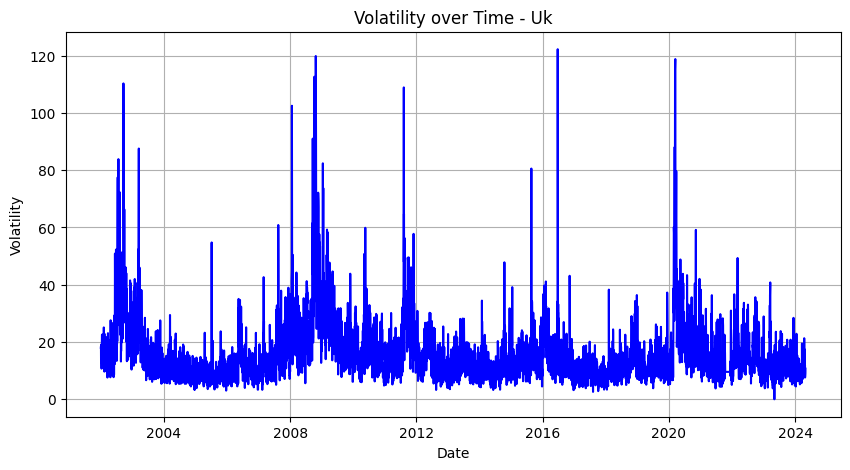

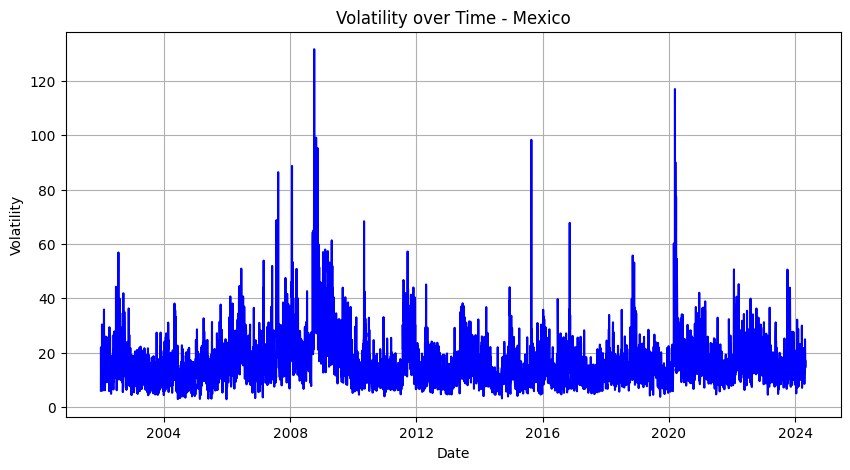

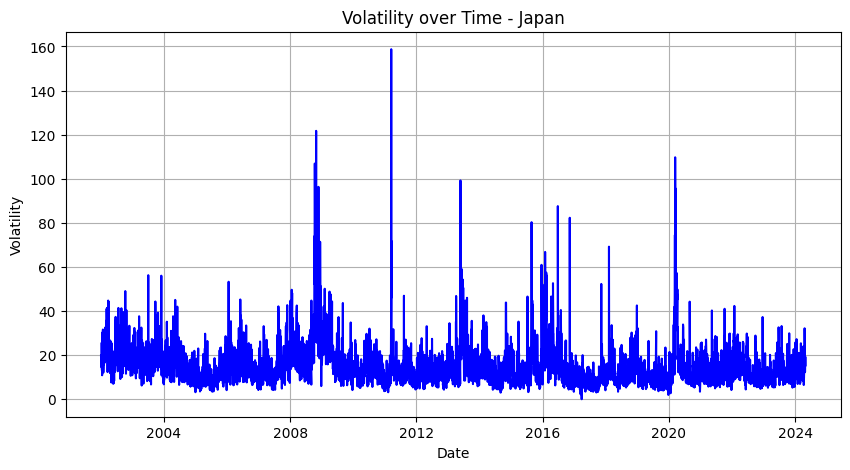

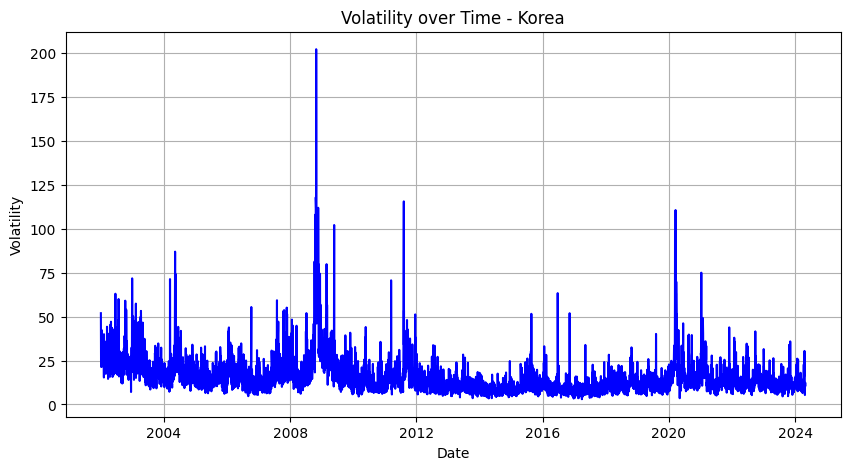

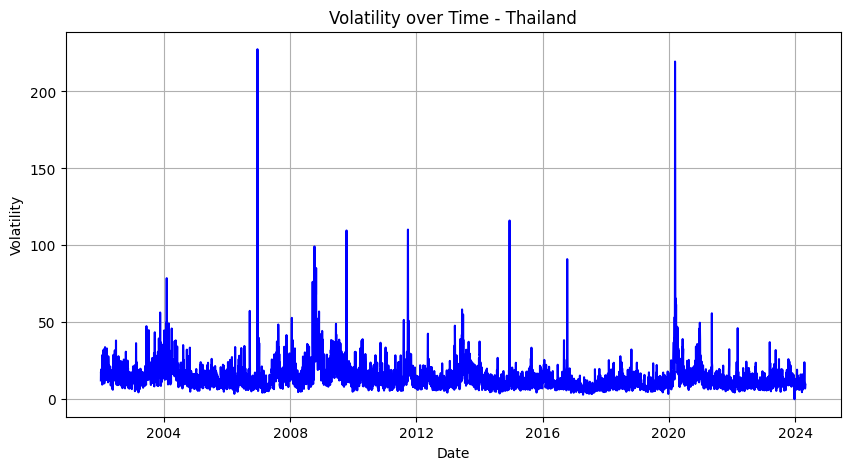

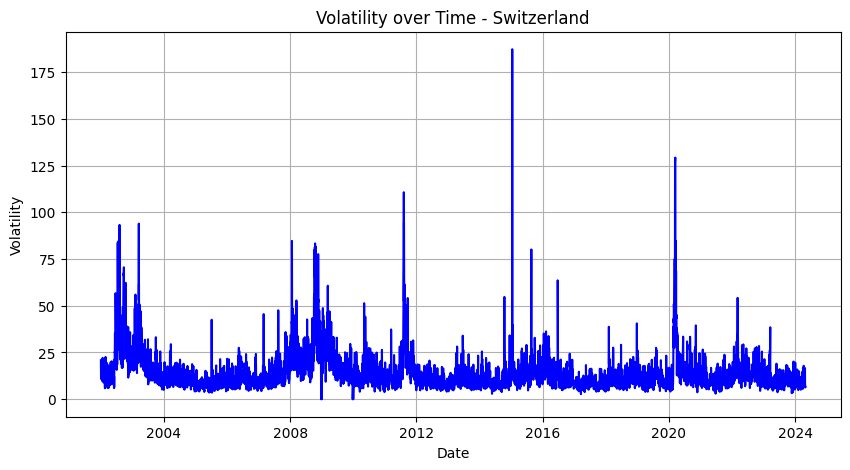

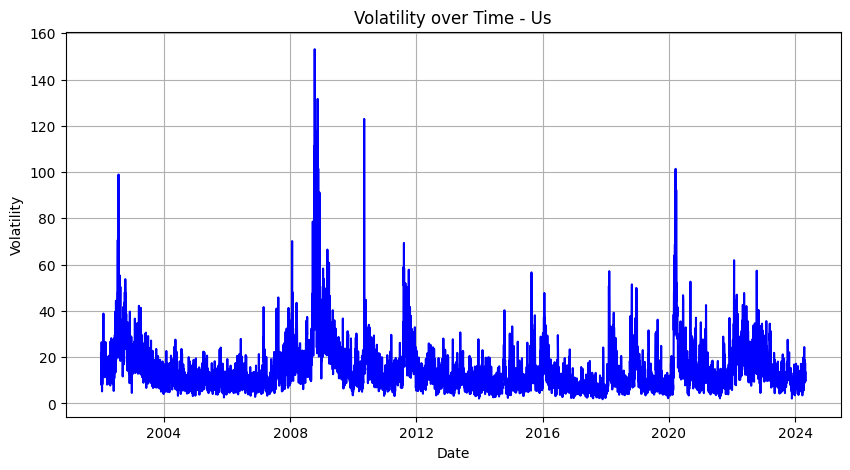

In [58]:
# Visualize the volatility of each country
for column in volatility_df.columns:
  plt.figure(figsize=(10, 5))
  plt.plot(volatility_df.index, volatility_df[column], label=column, color='blue')
  plt.title(f'Volatility over Time - {column.capitalize()}')
  plt.xlabel('Date')
  plt.ylabel('Volatility')
  plt.grid(True)
  plt.savefig(f'output/plots/volatility_{column.upper()}.png')  # Save the plot
  plt.show()


##### Augmented Dickey-Fuller (ADF) test

In [59]:
for country in volatility_df.columns:
  adf_test(volatility_df, country)

Results of Augmented Dickey-Fuller Test for uk:
ADF Statistic: -6.240839580494232
p-value: 4.701620665518484e-08
Critical Values:
	1%: -3.431478938567795
	5%: -2.8620388838347126
	10%: -2.567035553878898
Reject the null hypothesis. The time series uk is stationary.


Results of Augmented Dickey-Fuller Test for mexico:
ADF Statistic: -6.7110582149695945
p-value: 3.679790469568243e-09
Critical Values:
	1%: -3.4314799139042953
	5%: -2.862039314759095
	10%: -2.5670357832723325
Reject the null hypothesis. The time series mexico is stationary.


Results of Augmented Dickey-Fuller Test for japan:
ADF Statistic: -8.297506928092286
p-value: 4.1021193335394816e-13
Critical Values:
	1%: -3.4314777703843267
	5%: -2.8620383677062575
	10%: -2.567035279128919
Reject the null hypothesis. The time series japan is stationary.


Results of Augmented Dickey-Fuller Test for korea:
ADF Statistic: -7.706244778847388
p-value: 1.2993121296025538e-11
Critical Values:
	1%: -3.4314775759220844
	5%: -2.86203828178

All of the variables are stationary. Therefore, no transformation is needed.

## VAR Modelling

##### Average Spillover Table

In [60]:
print("Calculating spillover ...")
# Calculate the average spillover for each window
spillovers_table, lag_order, forecast_horizon = calculate_avg_spillover_table(
    volatility_df
)
print("Finished calculating spillover!")
print(f"Lag order: {lag_order}")
print(f"Forecast horizon: {forecast_horizon}")
print("Saving spillover table ...")
# Save the spillover table to a CSV file
spillovers_table.to_csv(
    "output/var/average_spillover_table.csv", index=True
)
print("Finished saving spillover table!")
print()
print(spillovers_table)

Calculating spillover ...
Finished calculating spillover!
Lag order: 14
Forecast horizon: 10
Saving spillover table ...
Finished saving spillover table!

                                      uk      mexico      japan      korea  \
uk                             47.909719    7.433728   2.479124   2.613409   
mexico                          8.874072   62.985094   2.356071   1.872438   
japan                           6.825966    5.482039  60.715357   6.886316   
korea                           5.173698    4.114027   5.992750  66.750890   
thailand                        4.813754    3.788957   2.497534   3.246038   
switzerland                    23.492787    4.992672   2.888600   2.780536   
us                             14.060381   12.081502   2.847298   1.786757   
Directional TO others          63.240658   37.892926  19.061378  19.185494   
Directional TO including own  111.150376  100.878020  79.776735  85.936384   
Total spillover index          40.014528   40.014528  40.014528  4

##### Net Pair-wise Spillover Table

In [61]:
print(f"Calculating net pair-wise spillover...")
# Read the spillover table for the current window
spillover_table = pd.read_csv(f"output/var/average_spillover_table.csv", index_col=0)
# Calculate the net pair-wise spillover for the current window
normalized_spillover_table = spillover_table.drop(index=['Directional TO others', 'Directional TO including own', 'Total spillover index']).drop(columns=['Directional FROM others'])
net_pairwise_spillover_table = calculate_net_pairwise_spillover_table(normalized_spillover_table)
print(f"Finished calculating net pair-wise spillover!")
print(f"Saving net pair-wise spillover table...")
# Save the net pair-wise spillover table to a CSV file
net_pairwise_spillover_table.to_csv(f"output/var/net_pairwise_spillover_table.csv", index=True)
print(f"Finished saving net pair-wise spillover table!")
print()
print(net_pairwise_spillover_table)

Calculating net pair-wise spillover...
Finished calculating net pair-wise spillover!
Saving net pair-wise spillover table...
Finished saving net pair-wise spillover table!

                    uk     mexico       japan      korea   thailand  \
uk            0.000000  20.576336   62.097732  36.575563  34.913474   
mexico      -20.576336   0.000000   44.656683  32.022706  32.611281   
japan       -62.097732 -44.656683    0.000000 -12.765226  -8.139615   
korea       -36.575563 -32.022706   12.765226   0.000000  -4.617793   
thailand    -34.913474 -32.611281    8.139615   4.617793   0.000000   
switzerland -26.908348  13.211515   54.920210  48.740607  29.355857   
us           21.780365  62.959680  106.324325  91.717352  35.274929   

             switzerland          us  
uk             26.908348  -21.780365  
mexico        -13.211515  -62.959680  
japan         -54.920210 -106.324325  
korea         -48.740607  -91.717352  
thailand      -29.355857  -35.274929  
switzerland     0.000000

##### Rolling Window Spillover Table

In [62]:
window_size = 200
# Calculate the rolling spillover for every N days
rolling_spillover_table = calculate_rolling_spillover_table(volatility_df, window_size)

print(rolling_spillover_table)

Calculating rolling window spillover...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5626/5626 [08:10<00:00, 11.47it/s]

            Total Spillover Index
date                             
2002-10-08              49.906815
2002-10-09              49.817351
2002-10-10              49.859295
2002-10-11              49.835678
2002-10-14              49.214026
...                           ...
2024-04-24              38.511228
2024-04-25              38.962159
2024-04-26              39.938478
2024-04-29              39.994452
2024-04-30              39.682523

[5626 rows x 1 columns]


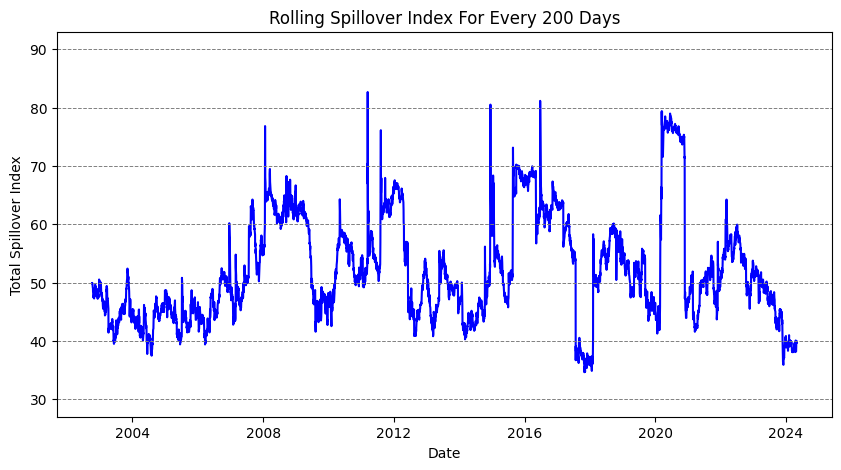

In [63]:
# Graph the rolling spillover
plt.figure(figsize=(10, 5))
plt.plot(rolling_spillover_table.index, rolling_spillover_table['Total Spillover Index'], label='Total spillover index', color='orange')
ax = plt.gca()
y_values = ax.get_yticks()
for y in y_values:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
plt.title(f'Rolling Spillover Index For Every {window_size} Days')
plt.xlabel('Date')
plt.ylabel('Total Spillover Index')

# Save the plot
plt.savefig(f'output/plots/{window_size}_days_rolling_spillover.png')

## Out of sample forecast

### VAR model prediction

##### Data preparation

In [64]:
# Split the data into training and test sets
var_train_size = int(len(volatility_df) - 10)
var_train_data = volatility_df[:var_train_size]
var_test_data = volatility_df[var_train_size:]


##### Forecast

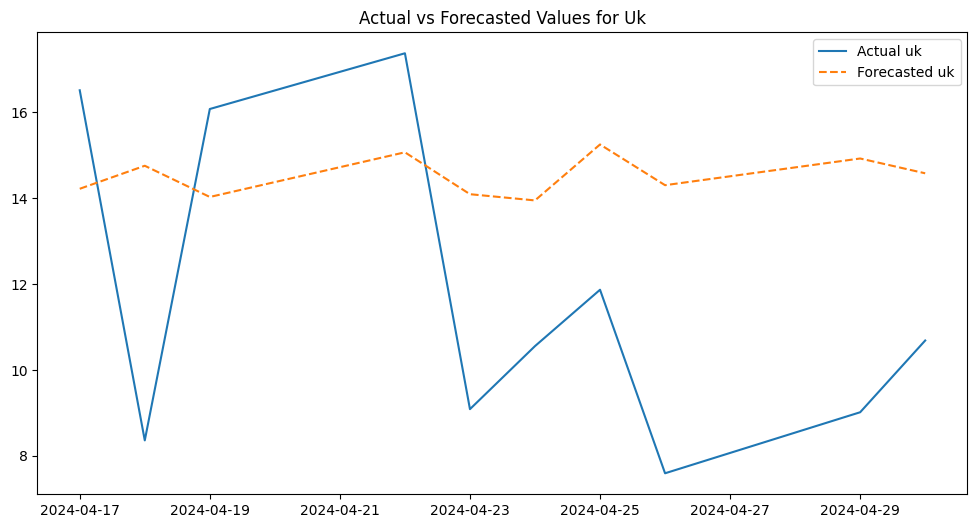

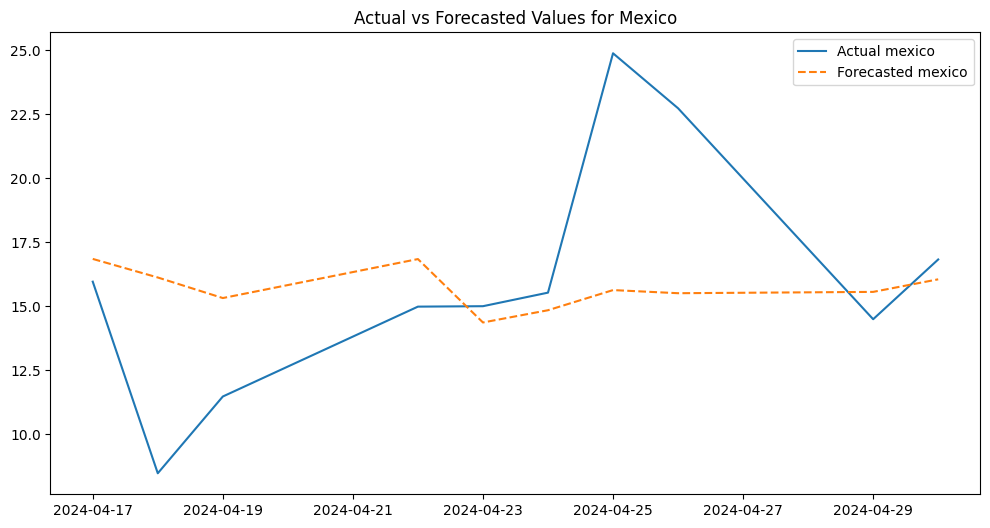

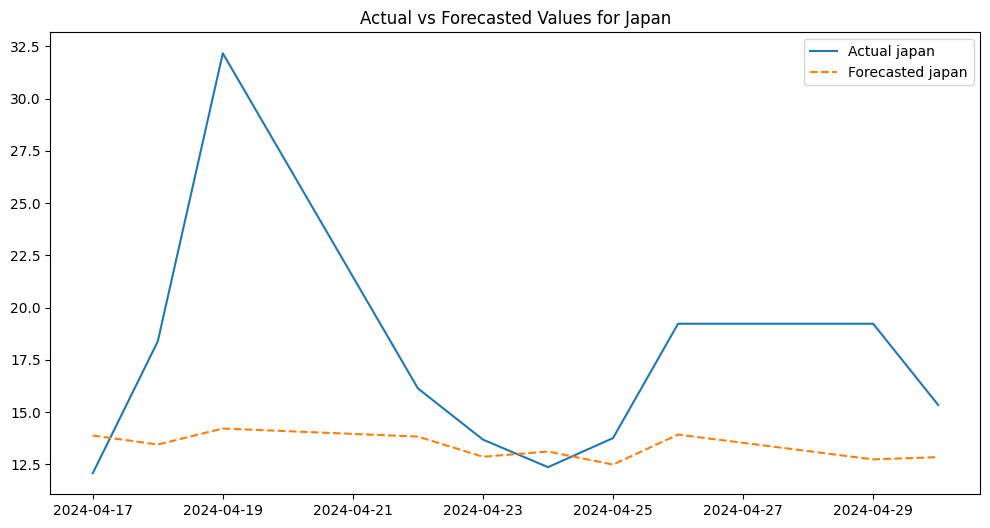

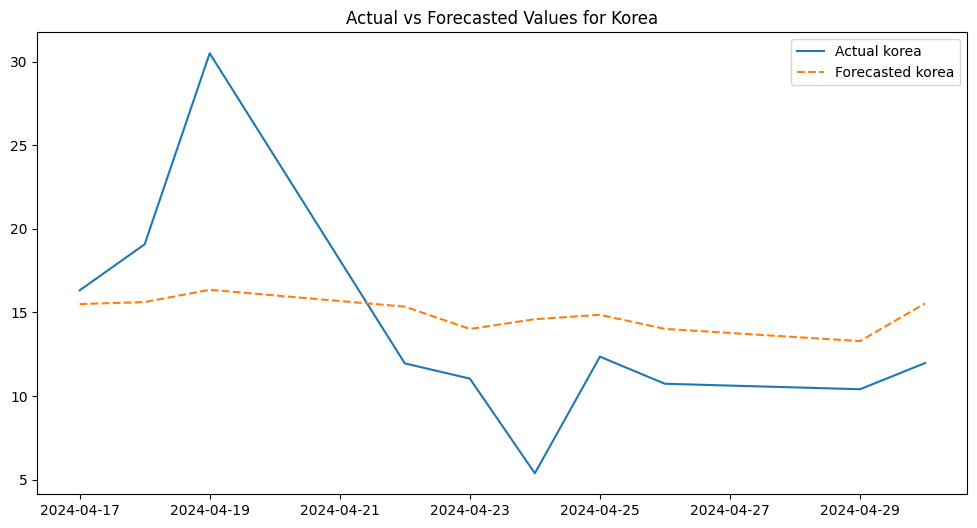

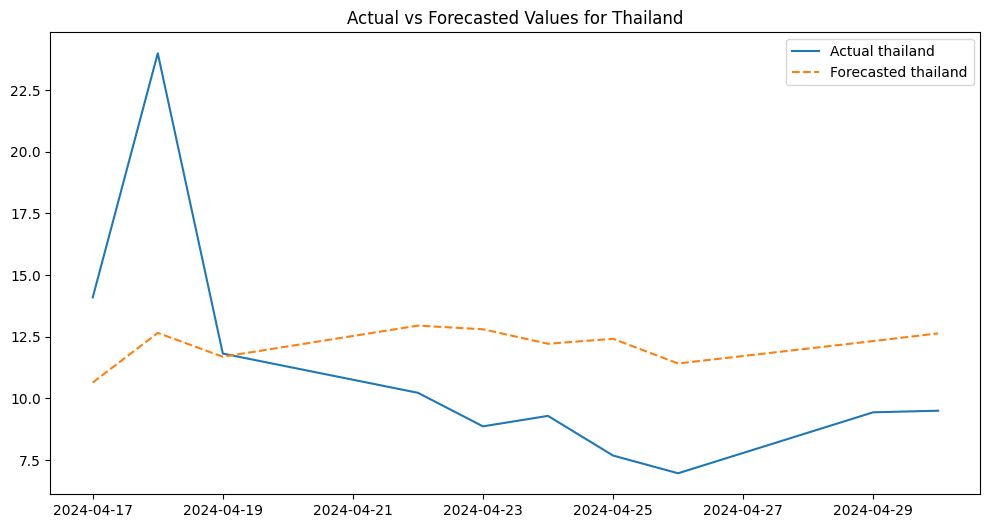

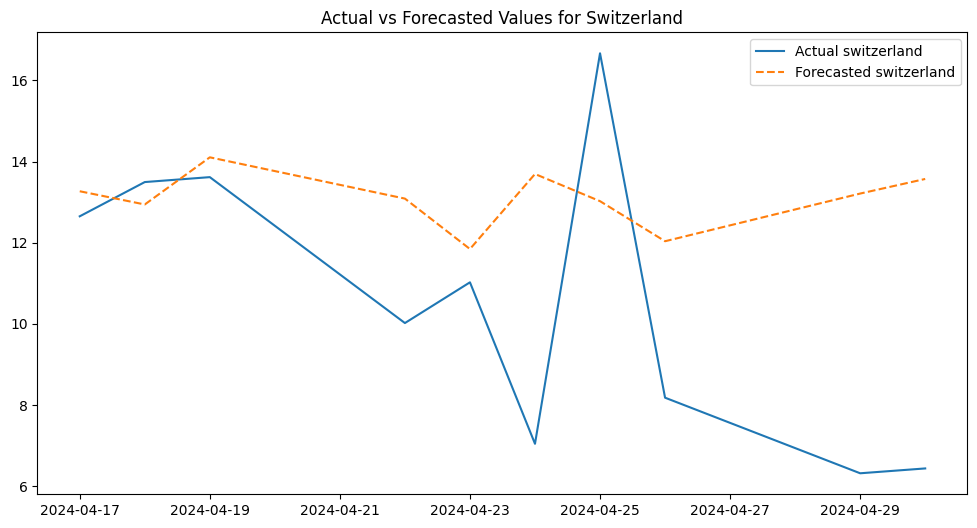

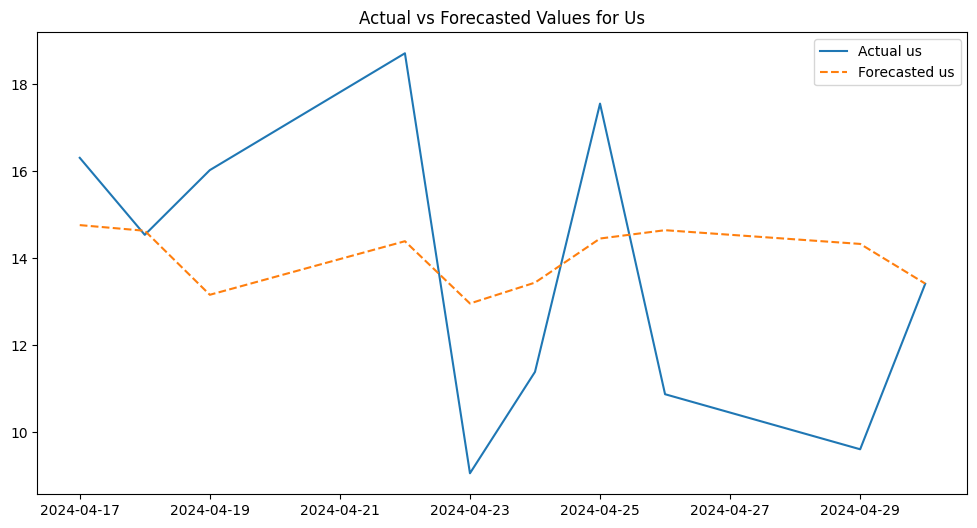

In [65]:
# Fit the VAR model with the training data
var_results, lag_order = fit_var(var_train_data)

# Generate the forecast for the test data
forecast = var_results.forecast(var_train_data.values[-var_results.k_ar:], steps=len(var_test_data))

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=var_test_data.index, columns=var_test_data.columns)

# Plot the actual vs forecasted values

for column in var_test_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(var_test_data.index, var_test_data[column], label=f'Actual {column}')
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecasted {column}', linestyle='--')

    plt.legend()
    plt.title(f'Actual vs Forecasted Values for {column.capitalize()}')

    # Save the plot
    plt.savefig(f'output/plots/var_actual_vs_forecasted_{column.upper()}.png')

##### Evaluation

In [66]:
# Calculate RMSE
mse_avg = mean_squared_error(var_test_data.values, forecast_df.values)
print(f'Average MSE: {mse_avg}')

for country in var_test_data.columns:
    mse = mean_squared_error(var_test_data[country], forecast_df[country])
    print(f'MSE for {country}: {mse}')

Average MSE: 24.524384444434354
MSE for uk: 19.891941255381813
MSE for mexico: 21.828587156177374
MSE for japan: 43.462535459762776
MSE for korea: 35.595434515238864
MSE for thailand: 23.24785605708474
MSE for switzerland: 18.167172483320048
MSE for us: 9.477164184074834


### LSTM model prediction

##### Data preparation

In [78]:
# Scale the data
volatility_df_scaled = np.log(volatility_df / volatility_df.shift(1))

print(volatility_df_scaled)

# # Split the data into training and test sets
# lstm_train_size = int(len(volatility_df) * 0.8)
# lstm_train_data = volatility_df[:lstm_train_size]
# lstm_test_data = volatility_df[lstm_train_size:]

# # Define the lag
# lag = 20

# # Function to split the data into X and y
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#         dataX.append(dataset[i - n_past:i])
#         dataY.append(dataset[i])
#     return np.array(dataX),np.array(dataY)

# # Define the training and test sets
# train_test_split = {}

# # Process the dataframes
# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(lstm_train_data)
# test_data_scaled = scaler.transform(lstm_test_data)

# # Split the data into X and y
# X_train, y_train = createXY(train_data_scaled, lag)
# X_test, y_test = createXY(test_data_scaled, lag)

# print(X_train.shape, y_train.shape)

                  uk    mexico     japan     korea  thailand  switzerland  \
date                                                                        
2002-01-02       NaN       NaN       NaN       NaN       NaN          NaN   
2002-01-03  0.027535  1.306741  0.000000 -0.698346  0.378508    -0.482366   
2002-01-04 -0.369481 -0.698322  0.000000 -0.187214 -0.084193    -0.156837   
2002-01-07  0.401877  0.269448 -0.157917  0.664940  0.131378     0.451705   
2002-01-08 -0.210643 -0.316419  0.017743 -0.595250 -0.374981    -0.349297   
...              ...       ...       ...       ...       ...          ...   
2024-04-24  0.149817  0.034729 -0.101377 -0.718592  0.046822    -0.447620   
2024-04-25  0.117229  0.471713  0.106684  0.830879 -0.190075     0.860951   
2024-04-26 -0.446650 -0.090348  0.334927 -0.140533 -0.098327    -0.711517   
2024-04-29  0.171628 -0.450631  0.000000 -0.030930  0.303885    -0.258260   
2024-04-30  0.170093  0.149486 -0.225899  0.139950  0.006824     0.018695   

##### Construct and train the models

In [74]:
def build_and_train_model(
    X_train, 
    y_train,
    units,
    dropout_rate,
    optimizer,
    learning_rate,
    epochs,
    batch_size,
):
    units = int(units)
    batch_size = int(batch_size)
    epochs = int(epochs)
    optimizer = int(round(optimizer))

    if optimizer == 0:
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 1:
        optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential()
    model.add(LSTM(units=units, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
    
    return model

# Function to run Bayesian Optimization for a single dataset
def optimize_lstm(X_train, y_train, X_test, y_test, scaler):
    y_test_inversed = scaler.inverse_transform(y_test[:10])

    # Define the hyperparameters
    pbounds = {
        'units': (64, 128),
        'dropout_rate': (0.2, 0.4),
        'optimizer': [0, 1],
        'learning_rate': (0.0001, 0.01),
        'batch_size': (16, 64),
        'epochs': (50, 100)
    }

    def optimization_function(units, dropout_rate, optimizer, learning_rate, batch_size, epochs):
        model = build_and_train_model(X_train, y_train, units, dropout_rate, optimizer, learning_rate, batch_size, epochs)
        y_pred = model.predict(X_test[:10])

        # Inverse transform the data
        y_pred_inversed = scaler.inverse_transform(y_pred)

        mse = mean_squared_error(y_test_inversed, y_pred_inversed)
        return -mse  # Return negative MSE for maximization
    
    optimizer = BayesianOptimization(
        f=optimization_function,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    
    optimizer.maximize(init_points=10, n_iter=15)
    
    return optimizer.max['params'], optimizer.max['target']

# Run Bayesian Optimization
print("Running Bayesian Optimization ...")
best_params, best_mse = optimize_lstm(X_train, y_train, X_test, y_test, scaler)
print("Finished running Bayesian Optimization!")
print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_mse}")
print()

# Fit the model with the best hyperparameters
print('Fitting the model with the best hyperparameters ...')
best_model = build_and_train_model(X_train, y_train, **best_params)
print('Finished fitting the model!')

Running Bayesian Optimization ...
|   iter    |  target   | batch_... | dropou... |  epochs   | learni... | optimizer |   units   |
-------------------------------------------------------------------------------------------------
1/1 [==============================] - 1s 1s/step
| 1         | -26.47    | 33.98     | 0.3901    | 86.6      | 0.006027  | 0.156     | 73.98     |
1/1 [==============================] - 1s 1s/step
| 2         | -45.21    | 18.79     | 0.3732    | 80.06     | 0.00711   | 0.02058   | 126.1     |
1/1 [==============================] - 1s 1s/step
| 3         | -24.87    | 55.96     | 0.2425    | 59.09     | 0.001916  | 0.3042    | 97.58     |
1/1 [==============================] - 1s 1s/step
| 4         | -24.99    | 36.73     | 0.2582    | 80.59     | 0.001481  | 0.2921    | 87.45     |
1/1 [==============================] - 3s 3s/step
| 5         | -26.26    | 37.89     | 0.357     | 59.98     | 0.005191  | 0.5924    | 66.97     |
1/1 [=========================

##### Models evaluation

1/1 [==============================] - 2s 2s/step


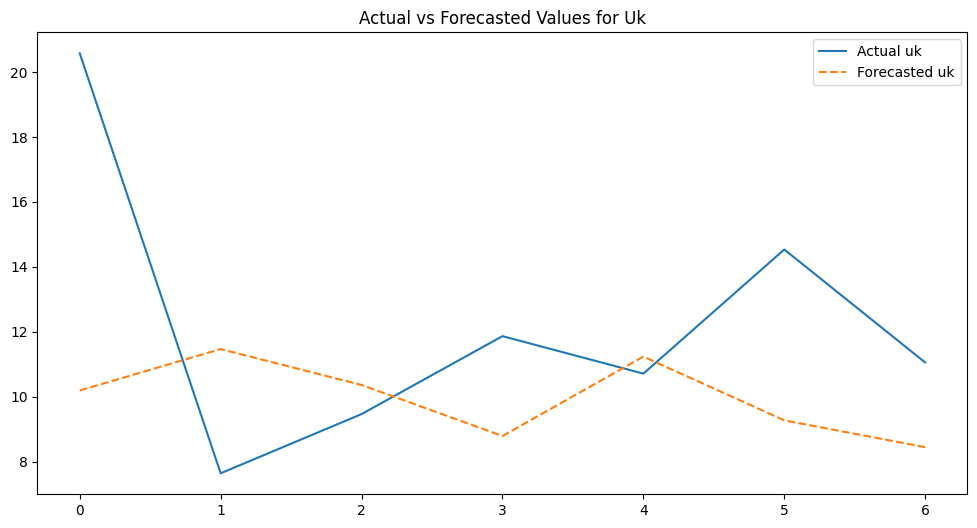

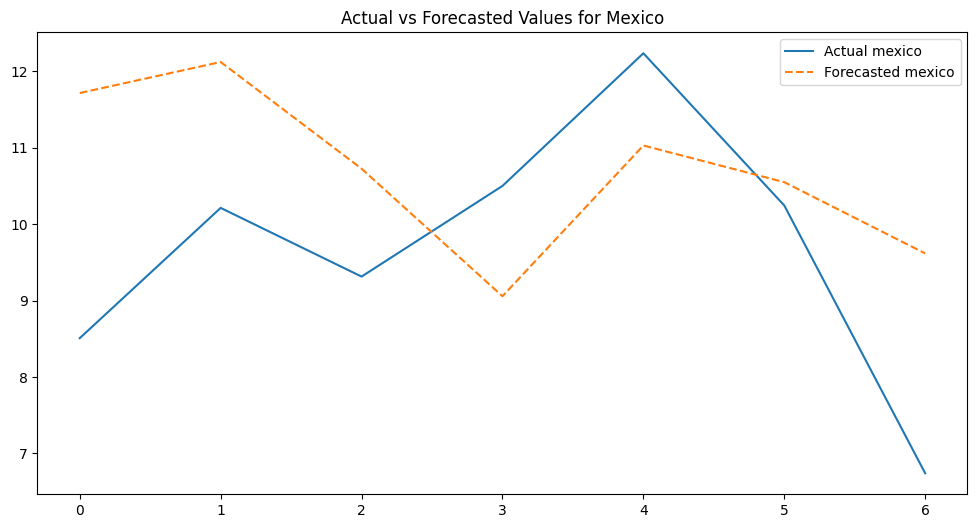

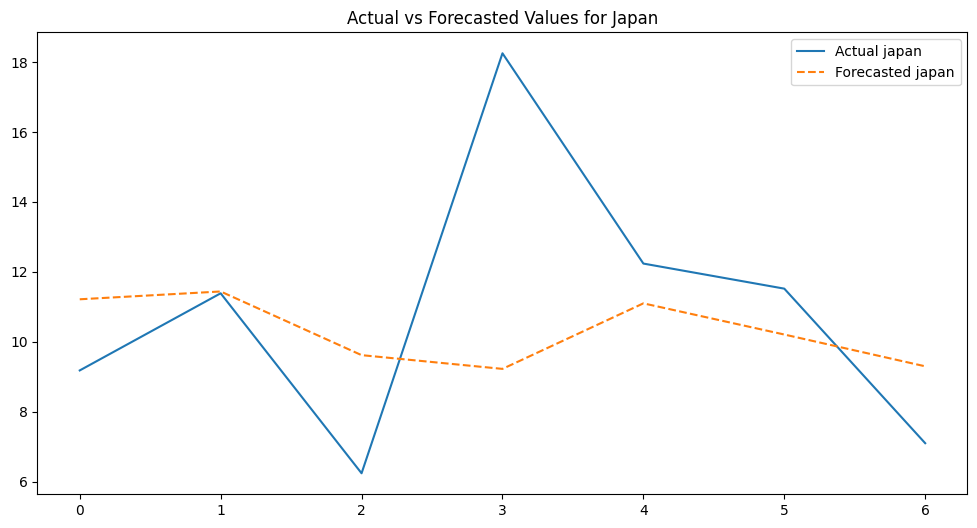

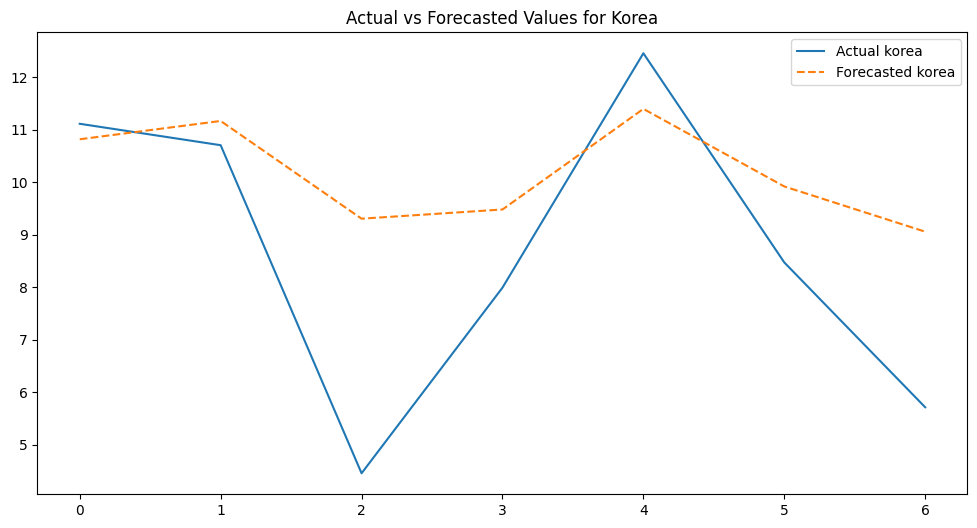

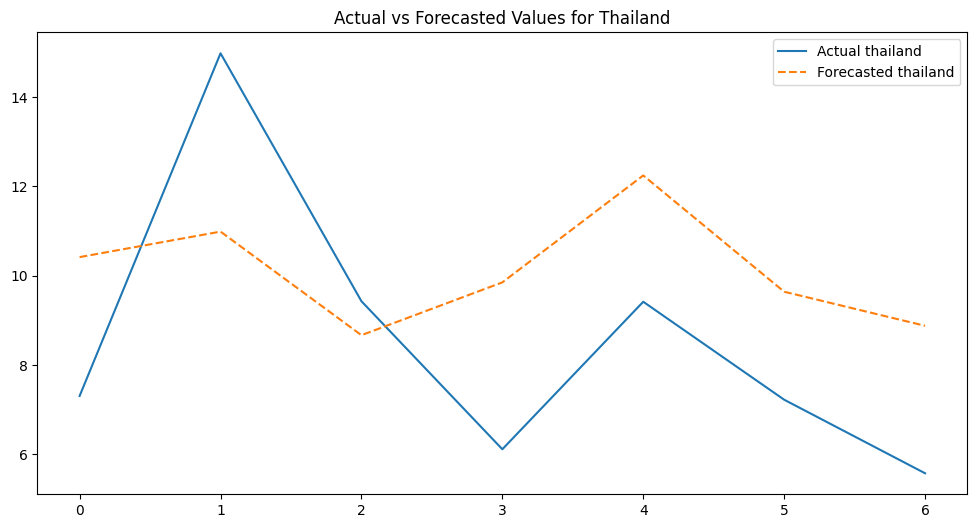

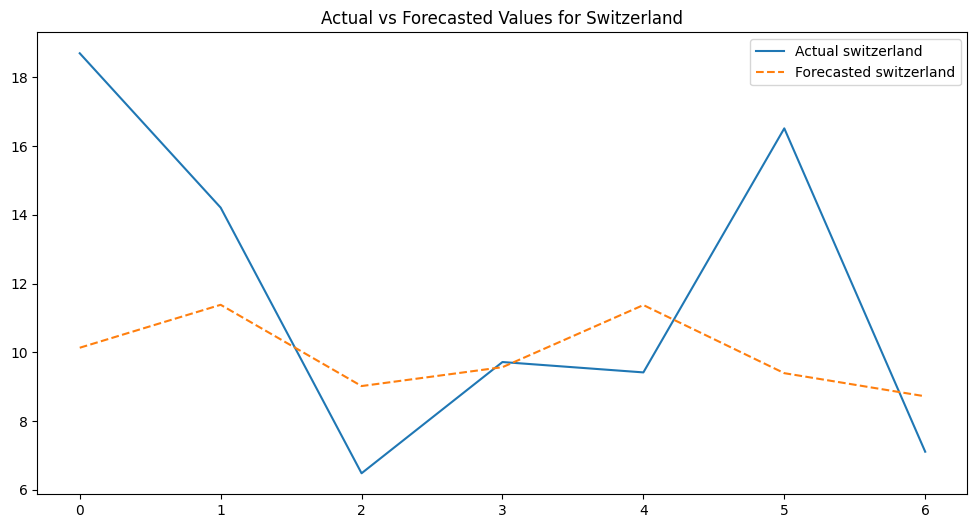

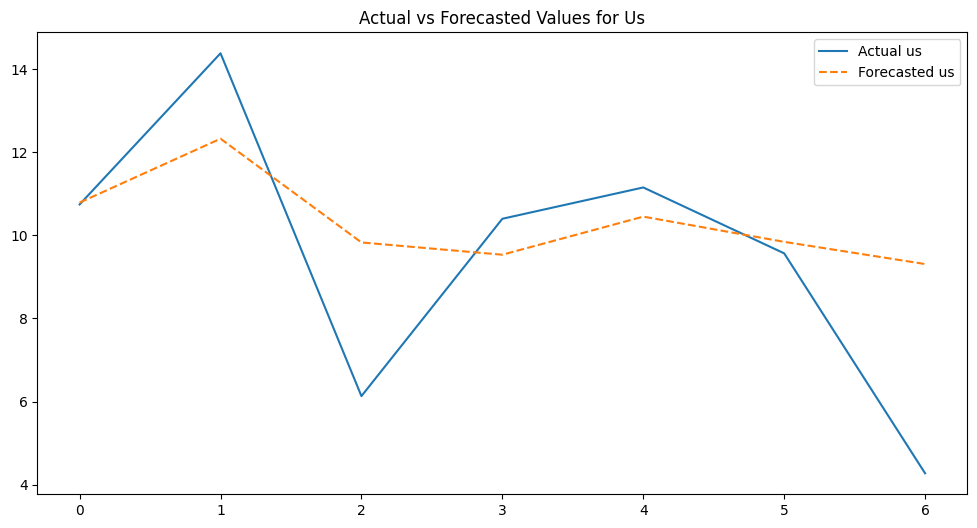

In [ ]:
# Generate the forecast for the test data 10 days ahead
y_pred = best_model.predict(X_test[:10])

# Inverse transform the data
y_test_inversed = scaler.inverse_transform(y_test[:10])
y_pred_inversed = scaler.inverse_transform(y_pred)

for ind, country in enumerate(lstm_test_data.columns):
  # Plot the actual vs forecasted values
  plt.figure(figsize=(12, 6))

  plt.plot(y_test_inversed[ind], label=f'Actual {country}')
  plt.plot(y_pred_inversed[ind], label=f'Forecasted {country}', linestyle='--')

  plt.legend()
  plt.title(f'Actual vs Forecasted Values for {country.capitalize()}')

  # Save the plot
  plt.savefig(f'output/plots/lstm_actual_vs_forecasted_{country.upper()}.png')

In [ ]:
# Calculate RMSE
mse_avg = mean_squared_error(y_test_inversed, y_pred_inversed)
print(f'Average MSE: {mse_avg}')

for ind, country in enumerate(lstm_test_data.columns):
    mse = mean_squared_error(y_test_inversed[ind], y_pred_inversed[ind])
    print(f'MSE for {country}: {mse}')

Average MSE: 25.04863067725803
MSE for uk: 23.9274082934681
MSE for mexico: 3.9823088771627533
MSE for japan: 14.965939762963652
MSE for korea: 5.77031202470787
MSE for thailand: 9.27192344655701
MSE for switzerland: 20.71762151899463
MSE for us: 6.370387767962212
